In [2]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [3]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2025-05-02 10:41:38--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.29.22.44, 2600:1406:5800:7a0::317f, 2600:1406:5800:79f::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.29.22.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  87.7MB/s    in 4.9s    

2025-05-02 10:41:43 (160 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [4]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


In [5]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# Create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from

  Returns:
    None
  """

  os.makedirs(os.path.join(root_path, 'training'))
  os.makedirs(os.path.join(f'{root_path}/training', 'dogs'))
  os.makedirs(os.path.join(f'{root_path}/training', 'cats'))
  os.makedirs(os.path.join(root_path, 'validation'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'dogs'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'cats'))

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [6]:
# Test create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/training/cats


In [8]:
# split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """

  # Shuffle list
  shuffled_source = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))

  # Find total number of files in training dir
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING_DIR

  for item in shuffled_source:
    item_source = os.path.join(SOURCE_DIR, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to validation
    if i == training_number:
      target = VALIDATION_DIR

In [9]:
# Test split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# The function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1249 images of cats for validation
There are 1249 images of dogs for validation


In [10]:
# train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale = 1. / 255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=45,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=5,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

  return train_generator, validation_generator

In [11]:
# Test the generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


In [12]:
# create_model
def create_model():

  model = tf.keras.models.Sequential([
      # The input shape is the desired size of the image 150x150 with 3 bytes color
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
      tf.keras.layers.Dense(1, activation='sigmoid'),
  ])

  from tensorflow.keras.optimizers import RMSprop

  model.compile(optimizer=RMSprop(learning_rate = 0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

In [13]:
# Get the untrained model
model = create_model()

# Train the model
# This may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
182/500 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.5621 - loss: 0.7566

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 95ms/step - accuracy: 0.6174 - loss: 0.6769 - val_accuracy: 0.7298 - val_loss: 0.5244
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.7544 - loss: 0.5045 - val_accuracy: 0.7678 - val_loss: 0.4675
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.8032 - loss: 0.4248 - val_accuracy: 0.7690 - val_loss: 0.4695
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.8408 - loss: 0.3566 - val_accuracy: 0.8243 - val_loss: 0.3824
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.8857 - loss: 0.2708 - val_accuracy: 0.8343 - val_loss: 0.4012
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 87ms/step - accuracy: 0.9248 - loss: 0.1884 - val_accuracy: 0.8383 - val_loss: 0.4367
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 86ms/step - accuracy: 0.9641 - loss: 0.1041 - val_accuracy: 0.8311 - val_loss: 0.5535
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.9820 - loss: 0.0533 - val_accurac

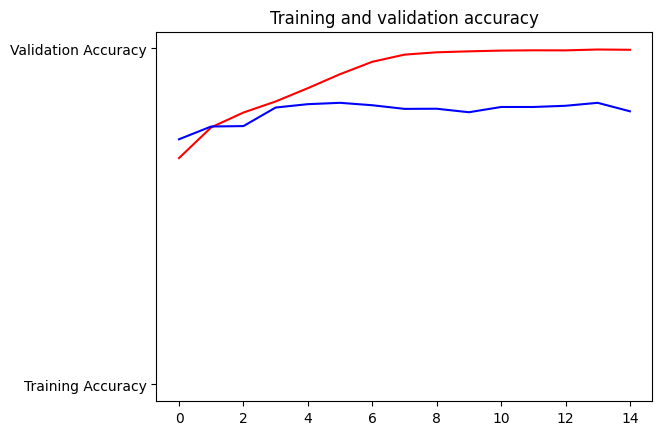

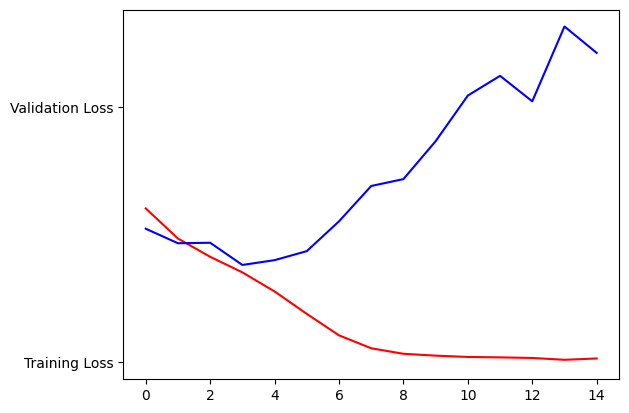

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()